<a href="https://colab.research.google.com/github/elieric/is843/blob/master/assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# D.C. Residential Properties Dataset Analysis
## Team: Big Daddy Data

**Data Source**:

Dataset was downloaded from https://www.kaggle.com/christophercorrea/dc-residential-properties

**Introduction**


Dataset ready for analysis showing real property information, including most recent sales price as of July 2018, for properties located Washington, D.C.

The source of the data is Open Data DC{1}, and the dataset utilized here, DC_Property_data.csv, was created by merging three OpenData.DC.gov source files: raw_residential_data.csv; raw_condominium_data.csv; & raw_address_points.csv.{2}

{1} https://opendata.dc.gov/ {2} https://www.kaggle.com/christophercorrea/preparing-the-d-c-real-property-dataset

**Columns in this Dataset**

|Column Name|Description|Type|
|--|--|--|
|ID|ID#|Int|
|BATHRM|Number of Full Bathrooms|Int|
|HF_BATHRM|Number of Half Bathrooms (no bathtub or shower)|Int|
|HEAT|Heating|String|
|AC|Cooling|String|
|NUM_UNITS|Number of Units|Int|
|ROOMS|Number of Rooms|Int|
|AYB|The earliest time the main portion of the building was built|Int|
|YR_RMDL|Year structure was remodeled|Int|
|EYB|The year an improvement was built more recent than actual year built|Int|
|STORIES|Number of stories in primary dwelling|Int|
|SALEDATE|Date of most recent sale|Timestamp|
|PRICE|Price of most recent sale|Int|
|QUALIFIED|Qualified|Boolean|
|SALE_NUM|Sale Number|Int|
|GBA|Gross building area in square feet|Int|
|BLDG_NUM|Building Number on Property|Int|
|STYLE|Style|String|
|STRUCT|Structure|String|
|GRADE|Grade|String|
|CNDTN|Condition|String|
|EXTWALL|Extrerior wall|String|
|ROOF|Roof type|String|
|INTWALL|Interior wall|String|
|KITCHENS|Number of kitchens|Int|
|FIREPLACES|Number of fireplaces|Int|
|USECODE|Property use code|Int|
|LANDAREA|Land area of property in square feet|Int|
|GIS_LAST_MOD_DTTM|Last Modified Date|Timestamp|
|SOURCE|Raw Data Source|String|
|CMPLX_NUM|Complex number|String|
|LIVING_GBA|Gross building area in square feet|String|
|FULLADDRESS|Full Street Address|String|
|CITY|City|String|
|STATE|State|String|
|ZIPCODE|Zip Code|Int|
|NATIONALGRID|Address location national grid coordinate spatial address|String|
|LATITUDE|Latitude|Int|
|LONGITUDE|Longitude|Int|
|ASSESSMENT_NBHD|Neighborhood ID|String|
|ASSESSMENT_SUBNBHD|Subneighborhood ID|String|
|CENSUS_TRACT|Census tract|Int|
|CENSUS_BLOCK|Census block|String|
|WARD|Ward (District is divided into eight wards, each with approximately 75,000 residents)|String|
|SQUARE|Square (from SSL)|Int|
|X|longitude|Int|
|Y|latitude|Int|
|QUADRANT|City quadrant (NE,SE,SW,NW)|String|

## Questions one could ask and find answers to from this dataset:
* Is there a model to predict the sale price of residental properties in D.C?
* What's the most relevant parameters to build up the model?
* Which area has the most expensive and which area has the least properties price?
* What's the properties sales trend in the last ten years?
* What's the best time of the year to sell a property?
* Create a graphic map using longtitude and latitude to indicate the sales of different area.

# *[Mise En Place](https://en.wikipedia.org/wiki/Mise_en_place)*
## If running in Google [Colaboratory](https://colab.research.google.com/): *Installing Java & Apache Spark*

*   the following cells only need to be run once per session
*   if applicable, check Files tab in left sidebar to see if installation has persistented from a previous session

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.2/spark-2.4.2-bin-hadoop2.7.tgz #update download URL as needed
!tar xf spark-2.4.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [1]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.2-bin-hadoop2.7" #set to download path

import findspark
findspark.init("/content/spark-2.4.2-bin-hadoop2.7") #set to download path

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.sql("select 'World' as Hello").show() # shows download & installation was successful

+-----+
|Hello|
+-----+
|World|
+-----+



## Preparing the Environment
### Installing necessary packages/modules
*   Only needs to be done once per session
*   Needs to be done if Notebook is being run on a GCP Cluster

In [0]:
!pip install --upgrade pip
!conda install pandas
!conda install scikit-learn
!pip install missingno

    100% |████████████████████████████████| 1.4MB 16.4MB/s 
  Found existing installation: pip 19.0.3
    Uninstalling pip-19.0.3:
      Successfully uninstalled pip-19.0.3
/bin/bash: conda: command not found
/bin/bash: conda: command not found


### Import packages
*   Only needs to be done once per runtime
  *   Needs to be down at least once each runtime

In [9]:
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

from pyspark.ml import Pipeline
from pyspark.ml import PipelineModel
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import RFormula
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import TrainValidationSplit

from pyspark.sql.functions import *

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn import metrics

from scipy import stats
from scipy.stats import norm, skew

from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import warnings
warnings.filterwarnings("ignore")

import lightgbm as lgb
from hyperopt import STATUS_OK

import altair as alt
import random
import itertools
import pprint
import ast
print('done')

done


### the Data
#### If running on Google Colaboratory: *download from Github*
Files:
*   `DC_Properties.csv`
*   `raw_census_tracts_in_2010.csv`

In [10]:
!wget -q https://github.com/elieric/is843/raw/master/DC_Properties.csv

df=\
  spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load("DC_Properties.csv")

print('done')

done


In [11]:
!wget -q https://github.com/elieric/is843/raw/master/raw_census_tracts_in_2010.csv

censusdata=\
  spark.read.format("csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load("raw_census_tracts_in_2010.csv")

print('done')

done


**If running the notebook on GCP***: *uncomment cells below*

In [0]:
# the following line gets the bucket name attached to our cluster
#bucket = spark._jsc.hadoopConfiguration().get("fs.gs.system.bucket")

#specifying the path to our bucket where the data is located (no need to edit this path anymore)
#data = "gs://" + bucket + "notebooks/data/"
#print('done')

Verify the datasource:

In [0]:
#!gsutil ls {data + "DC_Properties.csv"}
#!gsutil ls {data + "raw_census_tracts_in_2010.csv"}

gs://is843_bigdaddydata/data/DC_Properties.csv


Create dataframe

In [0]:
#df=\
#  spark.read.format("csv")\
#  .option("header", "true")\
#  .option("inferSchema", "true")\
#  .load(data + "DC_Properties.csv")
#print('done')

In [0]:
# censusdata = spark.read.format("csv")\
#   .option("header", "true")\
#   .option("inferSchema", "true")\
#   .load(data + "raw_census_tracts_in_2010.csv")
#print('done')

#### Caching & Partitioning the Dataframes
per `01-EDA.ipynb`

In [12]:
df = df.repartition(20)
print("DC dataset was re-partitioned to {} partitions!".format(df.rdd.getNumPartitions()))
spark.conf.set("spark.sql.shuffle.partitions", "20")
df.cache()

DC dataset was re-partitioned to 20 partitions!


DataFrame[_c0: int, BATHRM: int, HF_BATHRM: int, HEAT: string, AC: string, NUM_UNITS: double, ROOMS: int, BEDRM: int, AYB: double, YR_RMDL: double, EYB: int, STORIES: double, SALEDATE: timestamp, PRICE: double, QUALIFIED: string, SALE_NUM: int, GBA: double, BLDG_NUM: int, STYLE: string, STRUCT: string, GRADE: string, CNDTN: string, EXTWALL: string, ROOF: string, INTWALL: string, KITCHENS: double, FIREPLACES: int, USECODE: int, LANDAREA: int, GIS_LAST_MOD_DTTM: timestamp, SOURCE: string, CMPLX_NUM: double, LIVING_GBA: double, FULLADDRESS: string, CITY: string, STATE: string, ZIPCODE: double, NATIONALGRID: string, LATITUDE: double, LONGITUDE: double, ASSESSMENT_NBHD: string, ASSESSMENT_SUBNBHD: string, CENSUS_TRACT: double, CENSUS_BLOCK: string, WARD: string, SQUARE: string, X: double, Y: double, QUADRANT: string]

In [13]:
censusdata = censusdata.repartition(20)
print("censusdata dataset was re-partitioned to {} partitions!".format(censusdata.rdd.getNumPartitions()))
spark.conf.set("spark.sql.shuffle.partitions", "20")
censusdata.cache()

censusdata dataset was re-partitioned to 20 partitions!


DataFrame[OBJECTID: int, TRACT: int, GEOID: bigint, P0010001: int, P0010002: int, P0010003: int, P0010004: int, P0010005: int, P0010006: int, P0010007: int, P0010008: int, OP000001: int, OP000002: int, OP000003: int, OP000004: int, P0020002: int, P0020005: int, P0020006: int, P0020007: int, P0020008: int, P0020009: int, P0020010: int, OP00005: int, OP00006: int, OP00007: int, OP00008: int, P0030001: int, P0030003: int, P0030004: int, P0030005: int, P0030006: int, P0030007: int, P0030008: int, OP00009: int, OP00010: int, OP00011: int, OP00012: int, P0040002: int, P0040005: int, P0040006: int, P0040007: int, P0040008: int, P0040009: int, P0040010: int, OP000013: int, OP000014: int, OP000015: int, OP000016: int, H0010001: int, H0010002: int, H0010003: int, ACRES: double, SQ_MILES: double, Shape_Length: double, Shape_Area: double, FAGI_TOTAL_2010: double, FAGI_MEDIAN_2010: double, FAGI_TOTAL_2013: double, FAGI_MEDIAN_2013: double, FAGI_TOTAL_2011: int, FAGI_MEDIAN_2011: double, FAGI_TOTAL_

# Analyzing the Data
### `DC Properties`

`df` Schema

In [14]:
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- BATHRM: integer (nullable = true)
 |-- HF_BATHRM: integer (nullable = true)
 |-- HEAT: string (nullable = true)
 |-- AC: string (nullable = true)
 |-- NUM_UNITS: double (nullable = true)
 |-- ROOMS: integer (nullable = true)
 |-- BEDRM: integer (nullable = true)
 |-- AYB: double (nullable = true)
 |-- YR_RMDL: double (nullable = true)
 |-- EYB: integer (nullable = true)
 |-- STORIES: double (nullable = true)
 |-- SALEDATE: timestamp (nullable = true)
 |-- PRICE: double (nullable = true)
 |-- QUALIFIED: string (nullable = true)
 |-- SALE_NUM: integer (nullable = true)
 |-- GBA: double (nullable = true)
 |-- BLDG_NUM: integer (nullable = true)
 |-- STYLE: string (nullable = true)
 |-- STRUCT: string (nullable = true)
 |-- GRADE: string (nullable = true)
 |-- CNDTN: string (nullable = true)
 |-- EXTWALL: string (nullable = true)
 |-- ROOF: string (nullable = true)
 |-- INTWALL: string (nullable = true)
 |-- KITCHENS: double (nullable = true)
 

Showing the first 5 rows of the dataset

In [15]:
df.show(5, False)

+-----+------+---------+-------------+---+---------+-----+-----+------+-------+----+-------+-------------------+---------+---------+--------+------+--------+-------------+----------+-------------+-------+------------+------------+-------------+--------+----------+-------+--------+-------------------+-----------+---------+----------+---------------------+----------+-----+-------+------------------+-----------+------------+---------------+------------------+------------+------------+------+------+------------------+------------------+--------+
|_c0  |BATHRM|HF_BATHRM|HEAT         |AC |NUM_UNITS|ROOMS|BEDRM|AYB   |YR_RMDL|EYB |STORIES|SALEDATE           |PRICE    |QUALIFIED|SALE_NUM|GBA   |BLDG_NUM|STYLE        |STRUCT    |GRADE        |CNDTN  |EXTWALL     |ROOF        |INTWALL      |KITCHENS|FIREPLACES|USECODE|LANDAREA|GIS_LAST_MOD_DTTM  |SOURCE     |CMPLX_NUM|LIVING_GBA|FULLADDRESS          |CITY      |STATE|ZIPCODE|NATIONALGRID      |LATITUDE   |LONGITUDE   |ASSESSMENT_NBHD|ASSESSMENT_

Number of rows in data set

In [0]:
print(" The DC DataFrame has {} records".format(df.count()))

 The DC DataFrame has 158957 records


**Dropping duplicates**

In [16]:
print('before:', df.count())
df = df.drop_duplicates()
print('after:', df.count())

before: 158957
after: 158957


> *No duplicates!*

## The Clean-Up

### `NULL`s
Visualized using the Python module [missingno](https://github.com/ResidentMario/missingno)

In [0]:
# Pandas first
py_df = df.toPandas()

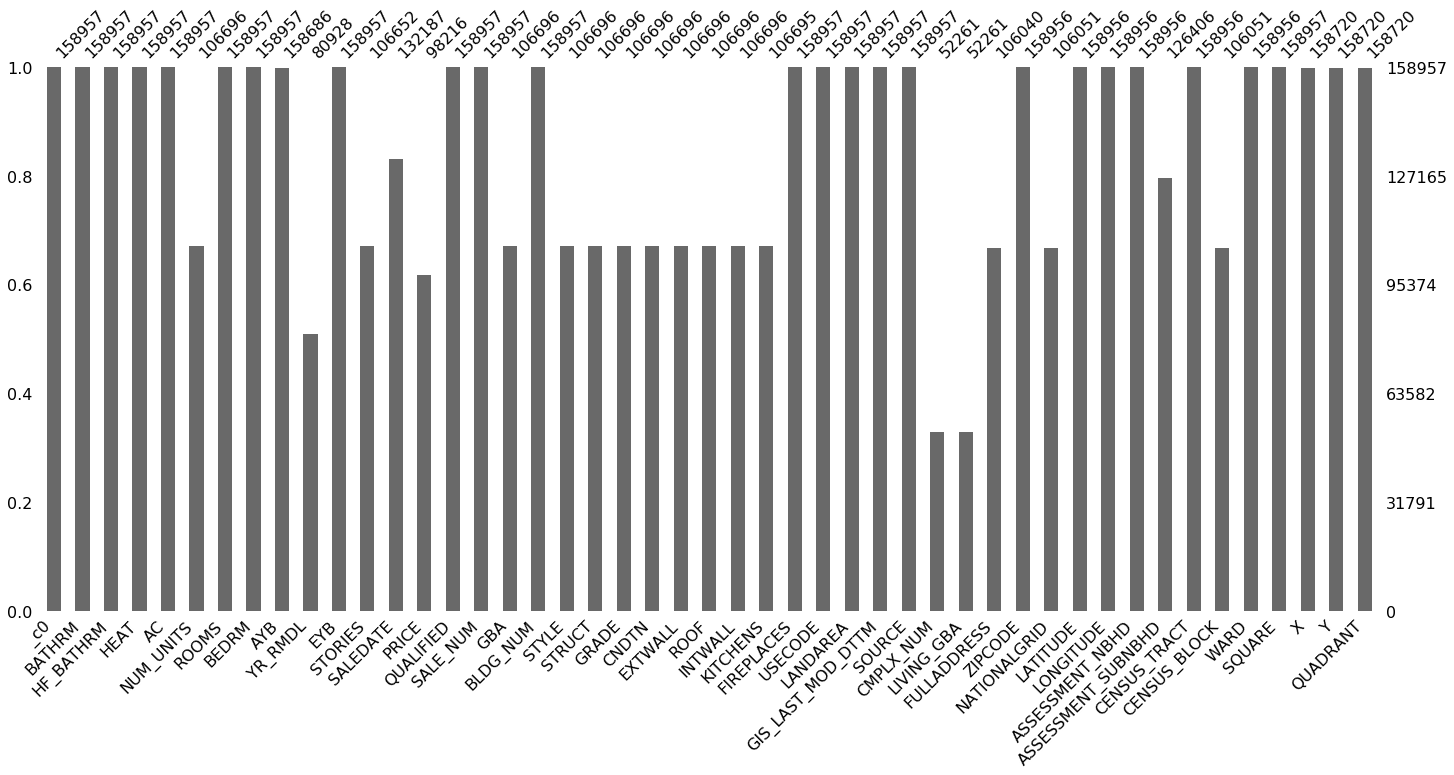

In [0]:
# barchart of how many cells have data in them 
# i.e. dark = data; white = missing data/NULL
msno.bar(py_df)

> *A lot of the data is missing;* <br> *Around 40% of the data is* `NULL` *in several of the categories.*

**Visualization question**: <br> How do `NULL`s propogate throughout the dataset?

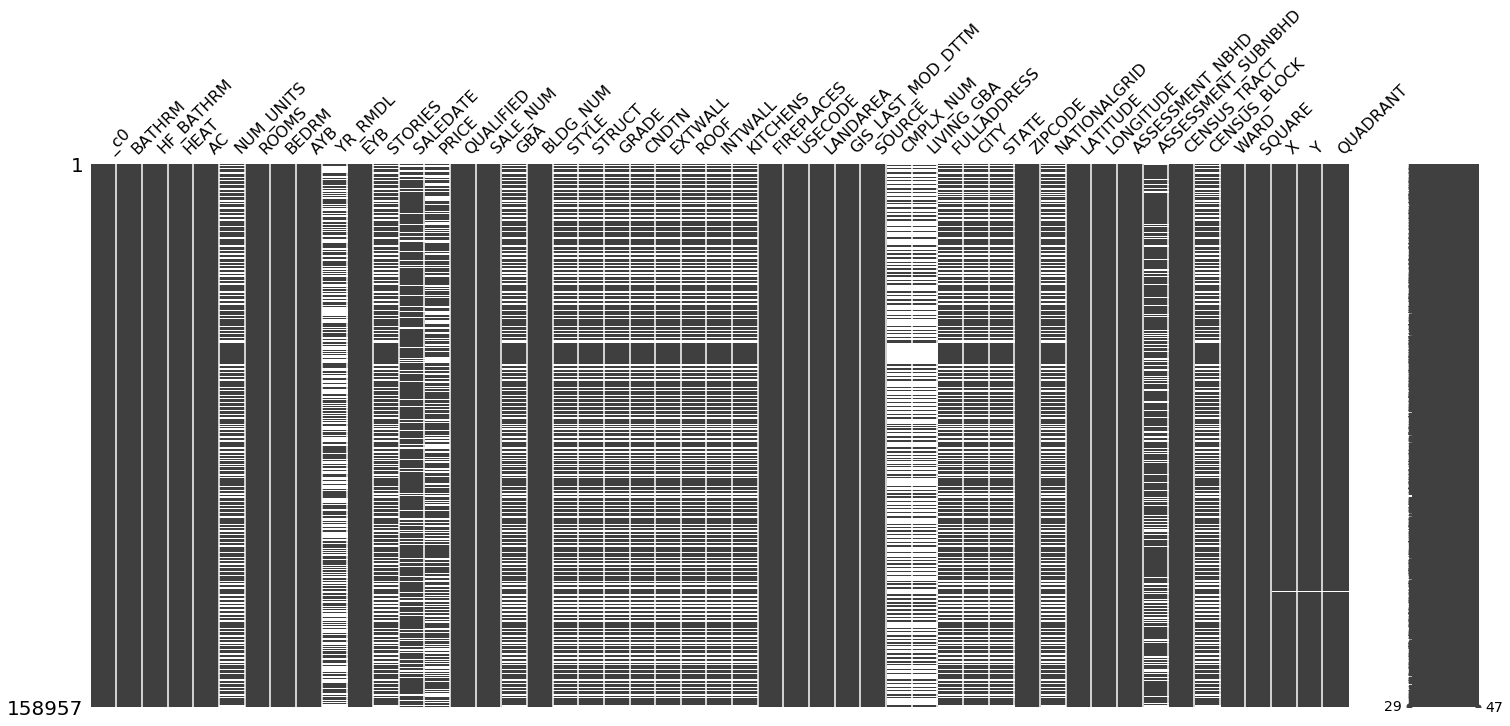

In [18]:
msno.matrix(py_df)

> `NULL` *data seems to propogate horizontally, i.e. tied to the row.* <br> *Let's see what happens when they are dropped.*

In [34]:
print('After dropping NULLs, there would be *{}* records remaining'.format(df.na.drop().count()))

After dropping NULLs, there would be *0* records remaining


> **Ruh-Roh** - *can't do that* <br>
*Let's look into* `NULL`s *further*

Using Gross Building Area ("GBA") to narrow search, as theoretically a building cannot exist if its area is `NULL`

In [36]:
GBA = df.where(~col("GBA").isNull())
LVG_GBA = df.where(~col("LIVING_GBA").isNull())
print('done')

done


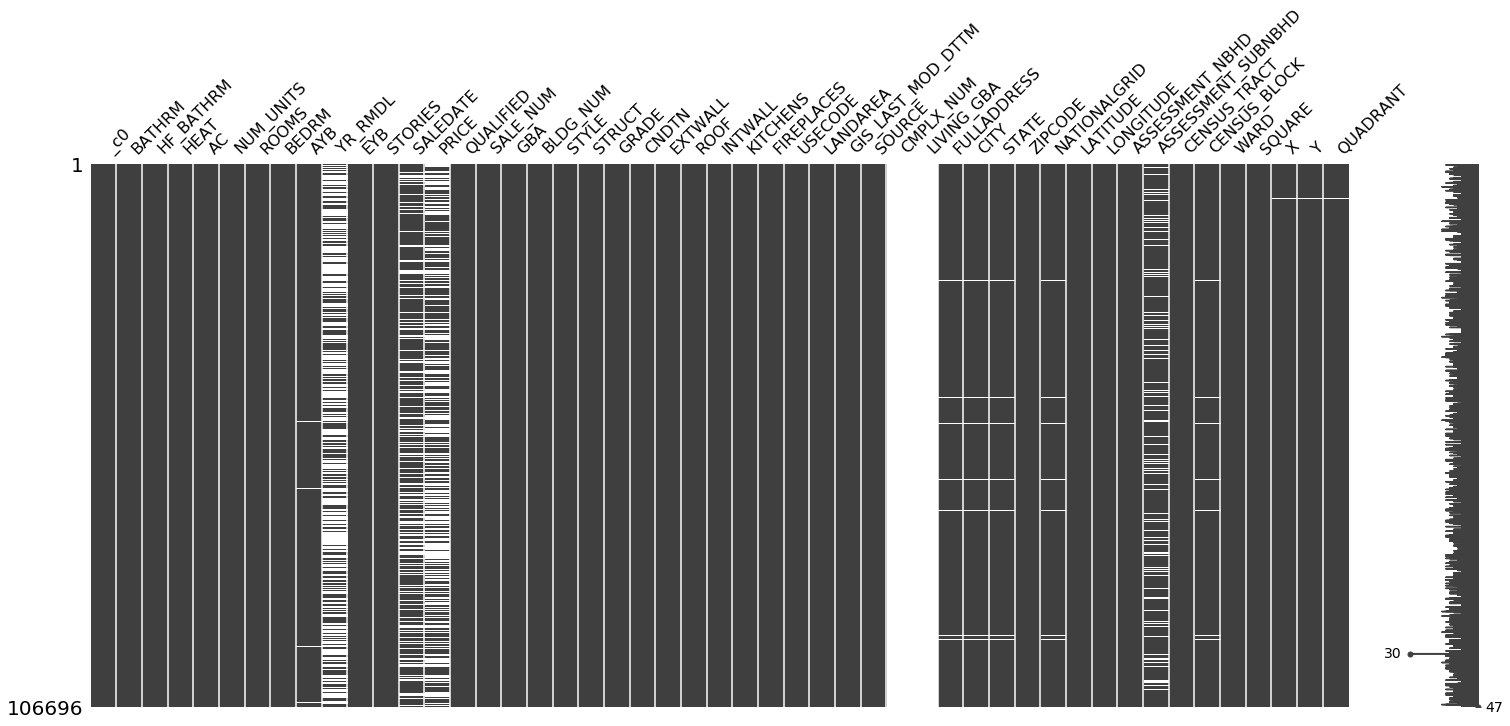

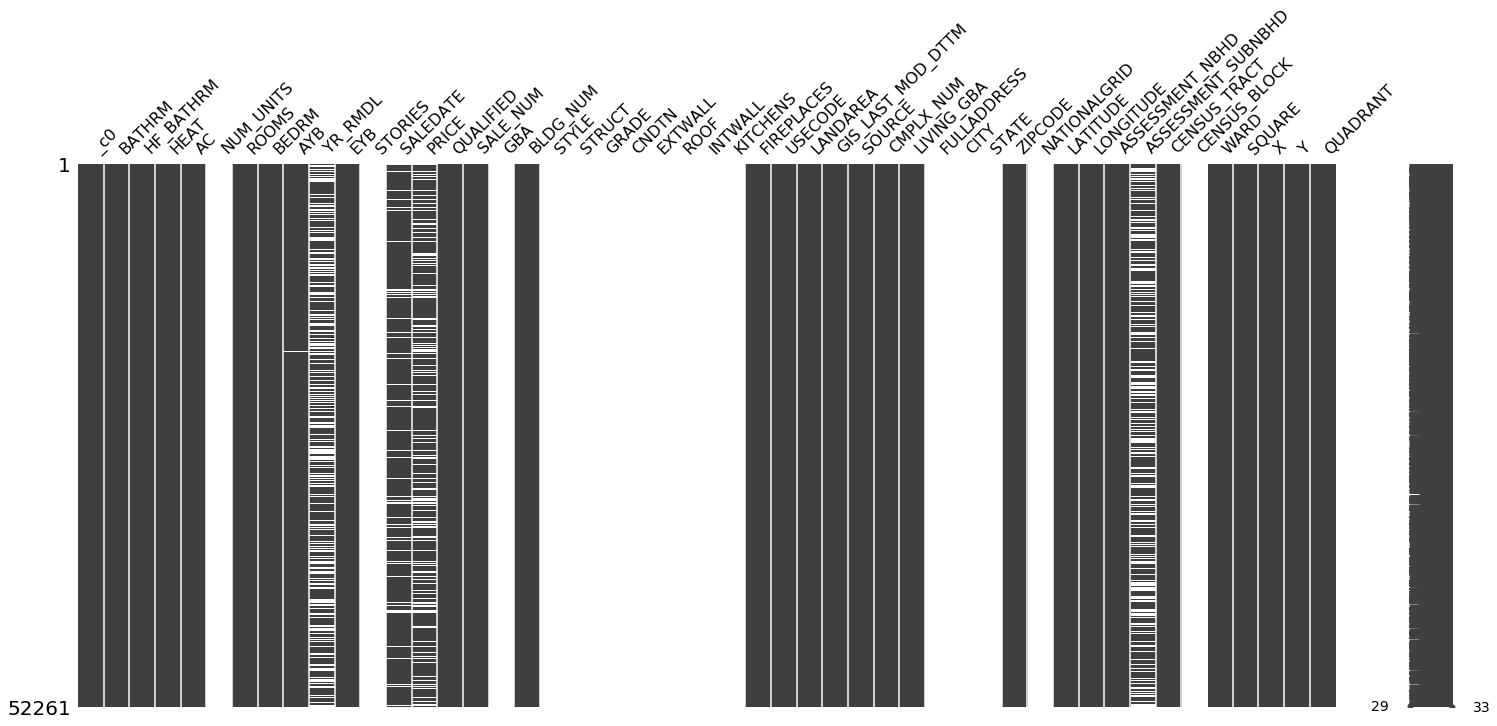

In [37]:
py_GBA = GBA.toPandas()
py_LVG_GBA = LVG_GBA.toPandas()

msno.matrix(py_GBA)
msno.matrix(py_LVG_GBA)

> *Well something seems weird.<br> Let's look at the data*

In [38]:
GBA.show(10)

+-----+------+---------+-------------+---+---------+-----+-----+------+-------+----+-------+-------------------+---------+---------+--------+------+--------+-------------+----------+-------------+---------+------------+------------+-------------+--------+----------+-------+--------+-------------------+-----------+---------+----------+--------------------+----------+-----+-------+------------------+-----------+------------+----------------+--------------------+------------+------------+------+------+------------------+------------------+--------+
|  _c0|BATHRM|HF_BATHRM|         HEAT| AC|NUM_UNITS|ROOMS|BEDRM|   AYB|YR_RMDL| EYB|STORIES|           SALEDATE|    PRICE|QUALIFIED|SALE_NUM|   GBA|BLDG_NUM|        STYLE|    STRUCT|        GRADE|    CNDTN|     EXTWALL|        ROOF|      INTWALL|KITCHENS|FIREPLACES|USECODE|LANDAREA|  GIS_LAST_MOD_DTTM|     SOURCE|CMPLX_NUM|LIVING_GBA|         FULLADDRESS|      CITY|STATE|ZIPCODE|      NATIONALGRID|   LATITUDE|   LONGITUDE| ASSESSMENT_NBHD|  ASS

> **Interesting...**

In [39]:
Residential = df.where(col('SOURCE') == "Residential")
Residential.show(5)
print(GBA.count())
print(Residential.count())

+-----+------+---------+-------------+---+---------+-----+-----+------+-------+----+-------+-------------------+---------+---------+--------+------+--------+-------------+----------+-------------+-------+------------+----------+----------+--------+----------+-------+--------+-------------------+-----------+---------+----------+--------------------+----------+-----+-------+------------------+-----------+------------+---------------+------------------+------------+------------+------+------+------------------+------------------+--------+
|  _c0|BATHRM|HF_BATHRM|         HEAT| AC|NUM_UNITS|ROOMS|BEDRM|   AYB|YR_RMDL| EYB|STORIES|           SALEDATE|    PRICE|QUALIFIED|SALE_NUM|   GBA|BLDG_NUM|        STYLE|    STRUCT|        GRADE|  CNDTN|     EXTWALL|      ROOF|   INTWALL|KITCHENS|FIREPLACES|USECODE|LANDAREA|  GIS_LAST_MOD_DTTM|     SOURCE|CMPLX_NUM|LIVING_GBA|         FULLADDRESS|      CITY|STATE|ZIPCODE|      NATIONALGRID|   LATITUDE|   LONGITUDE|ASSESSMENT_NBHD|ASSESSMENT_SUBNBHD|CENS

> *Well okay~ let's look at* `LIVING_GBA`

In [40]:
LIVING_GBA = df.where(~col("LIVING_GBA").isNull())
LIVING_GBA.show(10)

+------+------+---------+-------------+---+---------+-----+-----+------+-------+----+-------+-------------------+--------+---------+--------+----+--------+-----+------+-----+-----+-------+----+-------+--------+----------+-------+--------+-------------------+-----------+---------+----------+-----------+----+-----+-------+------------+------------------+------------------+----------------+--------------------+------------+------------+------+------+------------------+------------------+--------+
|   _c0|BATHRM|HF_BATHRM|         HEAT| AC|NUM_UNITS|ROOMS|BEDRM|   AYB|YR_RMDL| EYB|STORIES|           SALEDATE|   PRICE|QUALIFIED|SALE_NUM| GBA|BLDG_NUM|STYLE|STRUCT|GRADE|CNDTN|EXTWALL|ROOF|INTWALL|KITCHENS|FIREPLACES|USECODE|LANDAREA|  GIS_LAST_MOD_DTTM|     SOURCE|CMPLX_NUM|LIVING_GBA|FULLADDRESS|CITY|STATE|ZIPCODE|NATIONALGRID|          LATITUDE|         LONGITUDE| ASSESSMENT_NBHD|  ASSESSMENT_SUBNBHD|CENSUS_TRACT|CENSUS_BLOCK|  WARD|SQUARE|                 X|                 Y|QUADRANT|
+-

In [42]:
Condo = df.where(F.col('SOURCE') == "Condominium")
Condo.show(5)
print(LIVING_GBA.count())
print(Condo.count())

+------+------+---------+-------------+---+---------+-----+-----+------+-------+----+-------+-------------------+--------+---------+--------+----+--------+-----+------+-----+-----+-------+----+-------+--------+----------+-------+--------+-------------------+-----------+---------+----------+-----------+----+-----+-------+------------+------------------+------------------+----------------+--------------------+------------+------------+------+------+------------------+------------------+--------+
|   _c0|BATHRM|HF_BATHRM|         HEAT| AC|NUM_UNITS|ROOMS|BEDRM|   AYB|YR_RMDL| EYB|STORIES|           SALEDATE|   PRICE|QUALIFIED|SALE_NUM| GBA|BLDG_NUM|STYLE|STRUCT|GRADE|CNDTN|EXTWALL|ROOF|INTWALL|KITCHENS|FIREPLACES|USECODE|LANDAREA|  GIS_LAST_MOD_DTTM|     SOURCE|CMPLX_NUM|LIVING_GBA|FULLADDRESS|CITY|STATE|ZIPCODE|NATIONALGRID|          LATITUDE|         LONGITUDE| ASSESSMENT_NBHD|  ASSESSMENT_SUBNBHD|CENSUS_TRACT|CENSUS_BLOCK|  WARD|SQUARE|                 X|                 Y|QUADRANT|
+-

*Whether the building was* `Residential` *or a* `Condominium` *determined what information is collected about it.* <br> *Ultimately, need to mainly work with the largest & cleanest dataset of the two, with regards to * `PRICE`

In [43]:
clean_House = Residential.where(~col("PRICE").isNull())
clean_Condo = Condo.where(~col("PRICE").isNull())

print(clean_House.count())
print(clean_Condo.count())

57900
40316


#### Going forward, we will be mainly working with D.C. Residential properties.

In [47]:
df = clean_House
print('df = clean_House')

df = clean_House


### timestamp data
**splitting up `SALEDATE`**

In [48]:
t = df\
  .select("*", F.unix_timestamp(F.col('SALEDATE'), 'yyyy-MM-dd HH:mm:ss').alias('ut'))\
  .select("*", F.from_unixtime('ut').alias('dty'))\
  .select("*", F.date_format('SALEDATE', 'yyyy').alias('SALE_YR'),
          F.date_format('SALEDATE', 'MM').alias('SALE_MO'),
          F.date_format('SALEDATE', 'dd').alias('SALE_D'))

t = t.drop('ut', 'dty')
print('done')

done


In [49]:
df = t
print('df = t')

df = t


*Re-looking at the data*

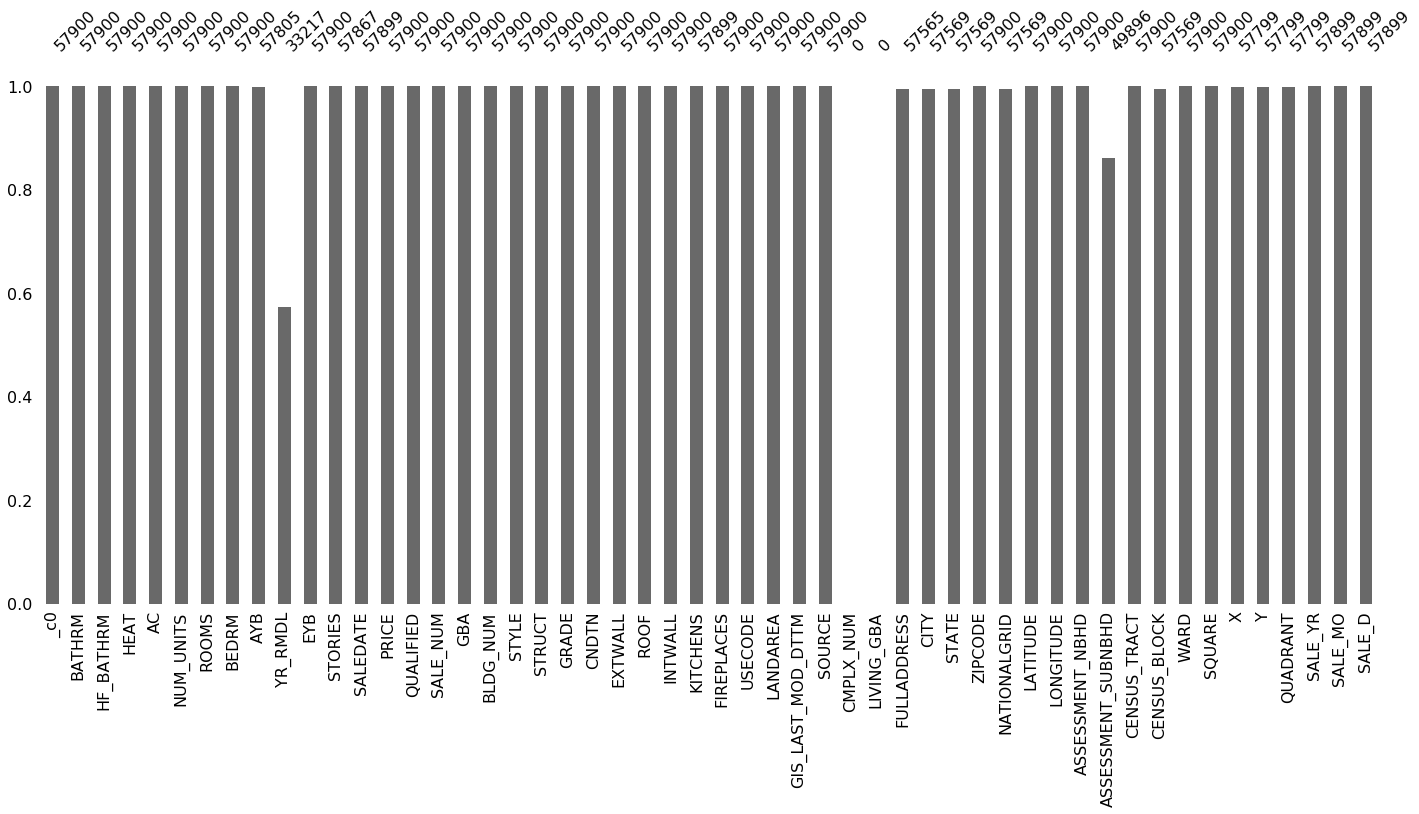

In [50]:
py_df = df.toPandas()

msno.bar(py_df)

In [51]:
df.show(10)

+-----+------+---------+-------------+---+---------+-----+-----+------+-------+----+-------+-------------------+---------+---------+--------+------+--------+-------------+----------+-------------+---------+------------+------------+-------------+--------+----------+-------+--------+-------------------+-----------+---------+----------+--------------------+----------+-----+-------+------------------+-----------+------------+---------------+------------------+------------+------------+------+------+------------------+------------------+--------+-------+-------+------+
|  _c0|BATHRM|HF_BATHRM|         HEAT| AC|NUM_UNITS|ROOMS|BEDRM|   AYB|YR_RMDL| EYB|STORIES|           SALEDATE|    PRICE|QUALIFIED|SALE_NUM|   GBA|BLDG_NUM|        STYLE|    STRUCT|        GRADE|    CNDTN|     EXTWALL|        ROOF|      INTWALL|KITCHENS|FIREPLACES|USECODE|LANDAREA|  GIS_LAST_MOD_DTTM|     SOURCE|CMPLX_NUM|LIVING_GBA|         FULLADDRESS|      CITY|STATE|ZIPCODE|      NATIONALGRID|   LATITUDE|   LONGITUDE|AS

In [53]:
print(df.columns)

['_c0', 'BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS', 'BEDRM', 'AYB', 'YR_RMDL', 'EYB', 'STORIES', 'SALEDATE', 'PRICE', 'QUALIFIED', 'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'USECODE', 'LANDAREA', 'GIS_LAST_MOD_DTTM', 'SOURCE', 'CMPLX_NUM', 'LIVING_GBA', 'FULLADDRESS', 'CITY', 'STATE', 'ZIPCODE', 'NATIONALGRID', 'LATITUDE', 'LONGITUDE', 'ASSESSMENT_NBHD', 'ASSESSMENT_SUBNBHD', 'CENSUS_TRACT', 'CENSUS_BLOCK', 'WARD', 'SQUARE', 'X', 'Y', 'QUADRANT', 'SALE_YR', 'SALE_MO', 'SALE_D']


*Dropping high-*`NULL` *and/or unnecessary columns*

In [63]:
house = df\
  .drop(
    '_c0',
    'YR_RMDL',
    'CMPLX_NUM',
    'LIVING_GBA',
    'FULLADDRESS',
    'CITY',
    'STATE',
    'NATIONALGRID',
    'ASSESSMENT_SUBNBHD',
    'X',
    'Y')

print('done')

done


*Filling in the rest*

In [64]:
d = house.toPandas()

d.AYB[d.AYB.isnull()] = d.AYB.mode().iloc[0]
d.EYB[d.EYB.isnull()] = d.EYB.mode().iloc[0]
d.STORIES[d.STORIES.isnull()] = d.STORIES.mode().iloc[0]
d.SALEDATE[d.SALEDATE.isnull()] = d.SALEDATE.mode().iloc[0]
d.KITCHENS[d.KITCHENS.isnull()] = d.KITCHENS.mode().iloc[0]
d.CENSUS_BLOCK[d.CENSUS_BLOCK.isnull()] = d.CENSUS_BLOCK.mode().iloc[0]
d.WARD[d.WARD.isnull()] = d.WARD.mode().iloc[0]
d.QUADRANT[d.QUADRANT.isnull()] = d.QUADRANT.mode().iloc[0]

d.SALE_YR[d.SALE_YR.isnull()] =  d.SALE_YR.mode().iloc[0]
d.SALE_MO[d.SALE_MO.isnull()] =  d.SALE_MO.mode().iloc[0]
d.SALE_D[d.SALE_D.isnull()] =  d.SALE_D.mode().iloc[0]

print('done')

done


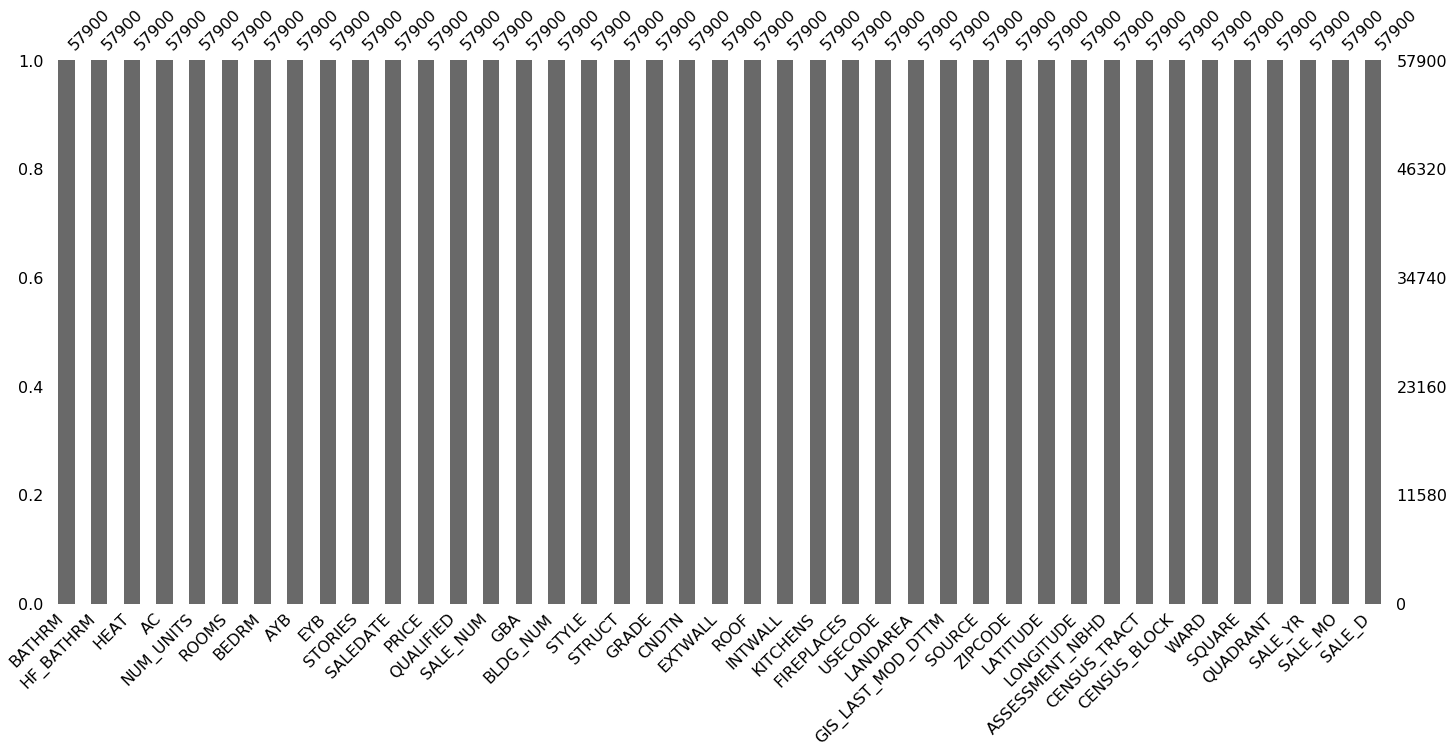

In [58]:
msno.bar(d)

### Cleaned-Up datasets
*   Python: **`d`**
*   Spark: **`house`**

In [60]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57900 entries, 0 to 57899
Data columns (total 41 columns):
BATHRM               57900 non-null int32
HF_BATHRM            57900 non-null int32
HEAT                 57900 non-null object
AC                   57900 non-null object
NUM_UNITS            57900 non-null float64
ROOMS                57900 non-null int32
BEDRM                57900 non-null int32
AYB                  57900 non-null float64
EYB                  57900 non-null int32
STORIES              57900 non-null float64
SALEDATE             57900 non-null datetime64[ns]
PRICE                57900 non-null float64
QUALIFIED            57900 non-null object
SALE_NUM             57900 non-null int32
GBA                  57900 non-null float64
BLDG_NUM             57900 non-null int32
STYLE                57900 non-null object
STRUCT               57900 non-null object
GRADE                57900 non-null object
CNDTN                57900 non-null object
EXTWALL              5790

## Incorporating `censusdata` into cleaned data

In [0]:
censusdata.printSchema()

root
 |-- OBJECTID: integer (nullable = true)
 |-- TRACT: integer (nullable = true)
 |-- GEOID: long (nullable = true)
 |-- P0010001: integer (nullable = true)
 |-- P0010002: integer (nullable = true)
 |-- P0010003: integer (nullable = true)
 |-- P0010004: integer (nullable = true)
 |-- P0010005: integer (nullable = true)
 |-- P0010006: integer (nullable = true)
 |-- P0010007: integer (nullable = true)
 |-- P0010008: integer (nullable = true)
 |-- OP000001: integer (nullable = true)
 |-- OP000002: integer (nullable = true)
 |-- OP000003: integer (nullable = true)
 |-- OP000004: integer (nullable = true)
 |-- P0020002: integer (nullable = true)
 |-- P0020005: integer (nullable = true)
 |-- P0020006: integer (nullable = true)
 |-- P0020007: integer (nullable = true)
 |-- P0020008: integer (nullable = true)
 |-- P0020009: integer (nullable = true)
 |-- P0020010: integer (nullable = true)
 |-- OP00005: integer (nullable = true)
 |-- OP00006: integer (nullable = true)
 |-- OP00007: integer 

In [0]:
censusdata.show(5)

+--------+-----+-----------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+------------+----------+----------------+----------------+---------------+----------------+---------------+----------------+---------------+----------------+---------------+----------------+---------------+----------------+---------------+----------------+
|OBJECTID|TRACT|      GEOID|P0010001|P0010002|P0010003|P0010004|P0010005|P0010006|P0010007|P0010008|OP000001|OP000002|OP000003|OP000004|P0020002|P0020005|P0020006|P0020007|P0020008|P0020009|P0020010|OP00005|OP00006|OP00007|OP00008|P0030001|P0030003|P0030004|P0030005|P0030006|P0030007|P00300

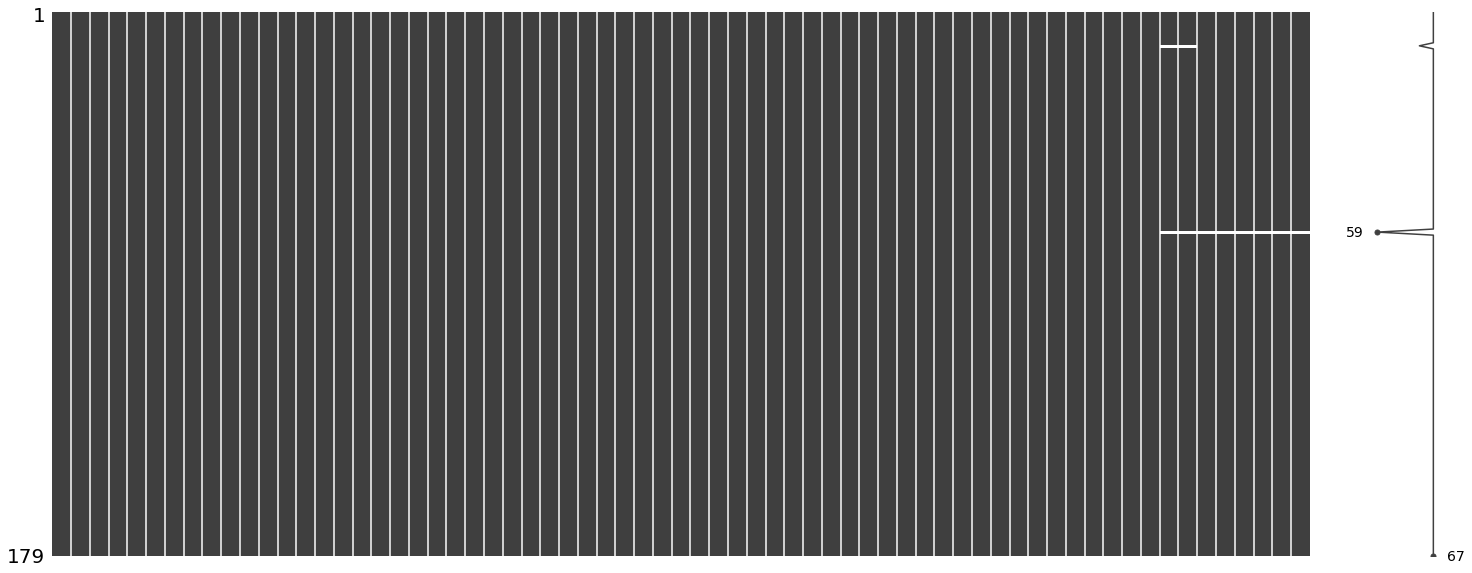

In [0]:
# NULLs here too?
py_censusdata = censusdata.toPandas()
msno.matrix(py_censusdata)

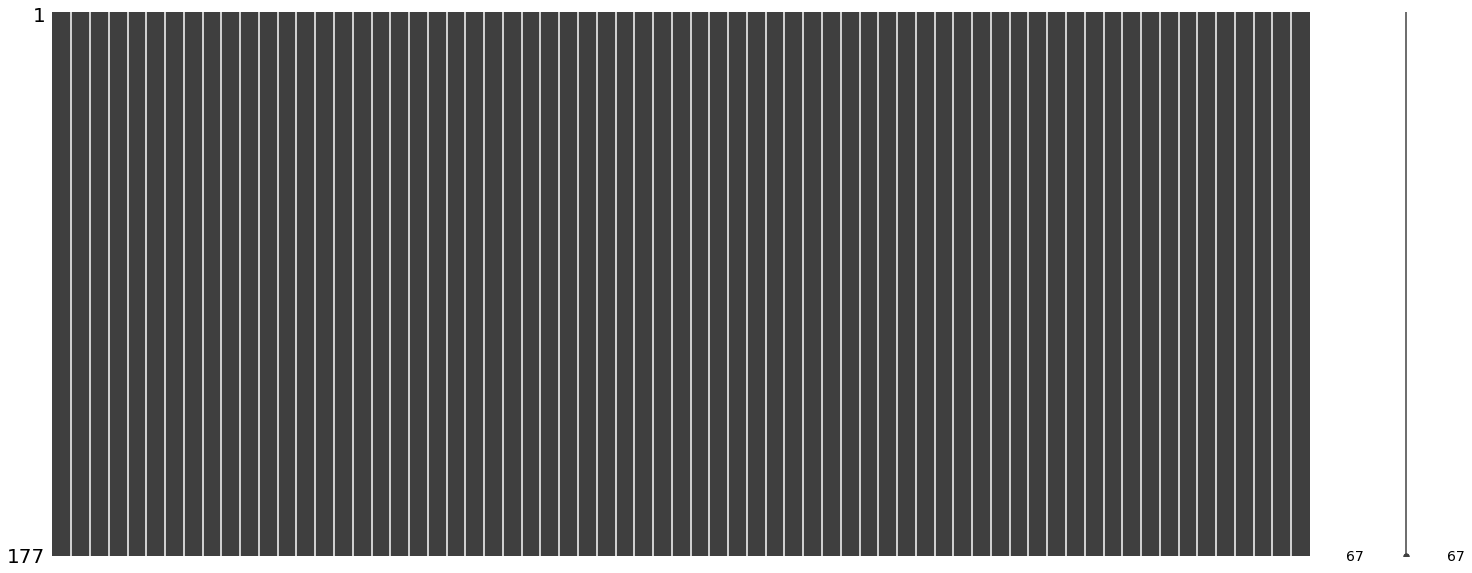

In [0]:
# whoops, step#2
censusdata = censusdata.na.drop()
py_censusdata = censusdata.toPandas()
msno.matrix(py_censusdata)

In [0]:
house.createOrReplaceTempView("house")
censusdata.createOrReplaceTempView("censusdata")

In [0]:
dfcd = house.join(censusdata, 
            on = house["CENSUS_TRACT"] == censusdata['TRACT'],
            how = "left")

In [0]:
dfcd.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- BATHRM: integer (nullable = true)
 |-- HF_BATHRM: integer (nullable = true)
 |-- HEAT: string (nullable = true)
 |-- AC: string (nullable = true)
 |-- NUM_UNITS: double (nullable = true)
 |-- ROOMS: integer (nullable = true)
 |-- BEDRM: integer (nullable = true)
 |-- AYB: double (nullable = true)
 |-- EYB: integer (nullable = true)
 |-- STORIES: double (nullable = true)
 |-- SALEDATE: timestamp (nullable = true)
 |-- PRICE: double (nullable = true)
 |-- QUALIFIED: string (nullable = true)
 |-- SALE_NUM: integer (nullable = true)
 |-- GBA: double (nullable = true)
 |-- BLDG_NUM: integer (nullable = true)
 |-- STYLE: string (nullable = true)
 |-- STRUCT: string (nullable = true)
 |-- GRADE: string (nullable = true)
 |-- CNDTN: string (nullable = true)
 |-- EXTWALL: string (nullable = true)
 |-- ROOF: string (nullable = true)
 |-- INTWALL: string (nullable = true)
 |-- KITCHENS: double (nullable = true)
 |-- FIREPLACES: integer (nullable = tru

In [0]:
dfcd.show()

+---+------+---------+-------------+---+---------+-----+-----+------+-------+----+-------+-------------------+---------+---------+--------+------+--------+-------+-------------+-------------+---------+------------+----------+--------+--------+----------+-------+--------+-------------------+-----------+---------+----------+--------------------+----------+-----+-------+------------------+------------------+------------+---------------+------------------+------------+------------+------+------+------------------+------------------+--------+--------+-----+-----------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+-------+-------+-------+-------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+------

In [0]:
house.count()

57900

## Characterizing the data

**Summary of col('`PRICE`')**

In [0]:
house.describe(['PRICE']).show()

+-------+-----------------+
|summary|            PRICE|
+-------+-----------------+
|  count|            57900|
|   mean|579911.8997927461|
| stddev| 607645.395956856|
|    min|              1.0|
|    max|           2.51E7|
+-------+-----------------+



**Describing PRICE after the year 2000**

In [68]:
df_new = dfcd.where(year("SALEDATE") >= 2000)
df_new.describe(['PRICE']).show()

+-------+-----------------+
|summary|            PRICE|
+-------+-----------------+
|  count|            51071|
|   mean|626709.6479411016|
| stddev|627000.8169204496|
|    min|              1.0|
|    max|           2.51E7|
+-------+-----------------+



#### Statistical methods to exclude outlying data

In [0]:
df_new = dfcd.where(year("SALEDATE") >= 2000)

# Calculate values used for outlier filtering
mean_val = df_new.agg({'PRICE': 'mean'}).collect()[0][0]
stddev_val = df_new.agg({'PRICE': 'stddev'}).collect()[0][0]

# Create three standard deviation (μ ± 3σ) lower and upper bounds for data
low_bound = mean_val - (3 * stddev_val)
hi_bound = mean_val + (3 * stddev_val)

# Filter the data to fit between the lower and upper bounds
df_new = df_new.where((df_new['PRICE'] < hi_bound) & (df_new['PRICE'] > low_bound))

In [72]:
df_new.describe(['PRICE']).show()

+-------+------------------+
|summary|             PRICE|
+-------+------------------+
|  count|             50390|
|   mean| 580803.5393728914|
| stddev|406996.62889121845|
|    min|               1.0|
|    max|         2505000.0|
+-------+------------------+



### Data Exploration
*   **Average PRICE grouped by ROOMS**

In [0]:
df_new.groupBy("ROOMS").avg("PRICE").orderBy("ROOMS").show()

+-----+------------------+
|ROOMS|        avg(PRICE)|
+-----+------------------+
|    0|       340397.8125|
|    1|           56130.0|
|    2| 388525.7894736842|
|    3|412834.41414141416|
|    4| 391291.3054318789|
|    5| 378214.4405449088|
|    6|455416.86231615377|
|    7| 544970.6694627522|
|    8| 671419.8040320561|
|    9| 813611.0380465644|
|   10| 887406.8715536814|
|   11|1059847.9799235181|
|   12| 766282.6992632285|
|   13| 1205726.525083612|
|   14| 975188.0045454545|
|   15|1205247.1623931625|
|   16|413486.47747747746|
|   17| 941642.8571428572|
|   18|        560261.875|
|   19|          889810.0|
+-----+------------------+
only showing top 20 rows



*   **Date range of house**

In [0]:
df_new.selectExpr("min(EYB)", "max(EYB)").show()

+--------+--------+
|min(EYB)|max(EYB)|
+--------+--------+
|    1915|    2018|
+--------+--------+



*   **Average PRICE grouped by LANDAREA?**

In [0]:
df_new.groupBy("LANDAREA").avg("PRICE").orderBy("LANDAREA").show()

+--------+-----------------+
|LANDAREA|       avg(PRICE)|
+--------+-----------------+
|       0|        1410434.1|
|     255|         210000.0|
|     268|         664150.0|
|     281|         590000.0|
|     288|         511000.0|
|     294|         387000.0|
|     327|427333.3333333333|
|     331|         660000.0|
|     350|         597500.0|
|     353|         650000.0|
|     356|         582000.0|
|     357|         567500.0|
|     360|         730000.0|
|     361|         690000.0|
|     362|         599100.0|
|     365|         729000.0|
|     374|         499000.0|
|     378|361333.3333333333|
|     397|         384300.0|
|     399|         519000.0|
+--------+-----------------+
only showing top 20 rows



*   **Average PRICE grouped by CNDTN (Condition)?**

In [73]:
df_new.groupBy("CNDTN").avg("PRICE").orderBy(desc("avg(PRICE)")).show()

+---------+------------------+
|    CNDTN|        avg(PRICE)|
+---------+------------------+
|Very Good| 791304.6786644951|
|Excellent| 765663.3324641461|
|     Good| 659323.3904341927|
|  Default|          499000.0|
|  Average|417289.55742686446|
|     Poor|360443.04938271607|
|     Fair| 347990.2044887781|
+---------+------------------+



*   **Average PRICE grouped by QUADRANT of house's location in Washington, D.C.?**

In [74]:
df.groupBy("QUADRANT").avg("PRICE").show()

+--------+------------------+
|QUADRANT|        avg(PRICE)|
+--------+------------------+
|    null| 454064.9405940594|
|      NE|402909.57000503835|
|      SE| 372380.3886045718|
|      NW| 790167.9848264318|
|      SW| 346137.7465753425|
+--------+------------------+



*   **How many house types are there based on Structure?**

In [0]:
df_new.select("STRUCT").distinct().count()

9

In [0]:
df_new.groupBy("STRUCT", "STYLE").count().orderBy("STYLE").show()

+-------------+---------------+-----+
|       STRUCT|          STYLE|count|
+-------------+---------------+-----+
|         null|           null|38027|
|   Row Inside|        1 Story|   27|
|Semi-Detached|        1 Story|   45|
|      Row End|        1 Story|   15|
|       Single|        1 Story| 1638|
|        Multi|        1 Story|    6|
|   Row Inside|  1.5 Story Fin|   14|
|Semi-Detached|  1.5 Story Fin|   27|
|        Multi|  1.5 Story Fin|    1|
|      Row End|  1.5 Story Fin|    2|
|       Single|  1.5 Story Fin|  934|
|Semi-Detached|1.5 Story Unfin|    4|
|      Row End|1.5 Story Unfin|    1|
|       Single|1.5 Story Unfin|   36|
|   Row Inside|1.5 Story Unfin|    2|
|        Multi|1.5 Story Unfin|    4|
|        Multi|        2 Story| 2318|
|      Default|        2 Story|    2|
|  Town Inside|        2 Story|   99|
|       Single|        2 Story| 7800|
+-------------+---------------+-----+
only showing top 20 rows



*   **Comparing house prices based on year and structure type**

In [75]:
df_new.groupBy("STRUCT").avg("PRICE").orderBy(desc("avg(PRICE)")).show()

+-------------+------------------+
|       STRUCT|        avg(PRICE)|
+-------------+------------------+
|      Default|         1016250.0|
|       Single| 710096.9454231951|
|   Row Inside| 588448.2909281995|
|      Row End| 575307.4983692107|
|     Town End| 414317.1052631579|
|  Town Inside|399895.26086956525|
|Semi-Detached|398752.62302138295|
|        Multi| 384621.6578112609|
+-------------+------------------+



# Visualization

## Find the trends for property sales by year. 

#### analysis the total sales count, average price and totoal sales value by each year.


In [0]:
from pyspark.sql import functions as F
sales_for_each_year = df_new.groupBy(F.year("SALEDATE").alias("Year"))\
                        .agg(F.count("_c0").alias("sales_count"),F.avg("PRICE").alias("avg_price"))\
                        .where(F.col("Year") >= 2000)\
                        .where(F.col("Year") <= 2017)\
                        .orderBy(F.desc("Year"))
sales_for_each_year.show()

+----+-----------+------------------+
|Year|sales_count|         avg_price|
+----+-----------+------------------+
|2017|       5215| 735048.2527325024|
|2016|       4182| 727581.2539454807|
|2015|       3788| 710220.4538014784|
|2014|       3454| 662188.9551244933|
|2013|       3221| 655933.4166407948|
|2012|       2753| 606756.0468579731|
|2011|       2475| 545346.4892929293|
|2010|       2334| 537998.8723221937|
|2009|       2181| 511925.3140761119|
|2008|       1745| 549053.5111747851|
|2007|       2089|  555421.049305888|
|2006|       2007| 529543.4394618834|
|2005|       2213| 532055.8350655219|
|2004|       2329| 425050.2232717905|
|2003|       1981|393309.25088339223|
|2002|       1911| 326075.0654107797|
|2001|       1799| 291235.3401889939|
|2000|       1634|257052.68727050183|
+----+-----------+------------------+



In [0]:
py_dc_data = sales_for_each_year.toPandas()
py_dc_data.head()

,Year,sales_count,avg_price
0,2017,5215,735048.252733
1,2016,4182,727581.253945
2,2015,3788,710220.453801
3,2014,3454,662188.955124
4,2013,3221,655933.416641


#### Use *matplotlib* for plotting

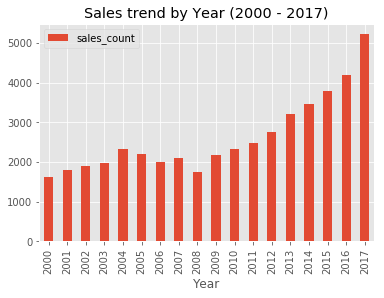

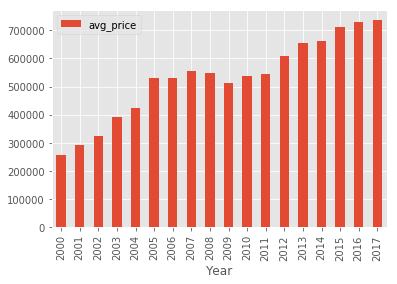

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
df1 = py_dc_data.set_index('Year')
df1[["sales_count" ]].plot.bar().invert_xaxis()
plt.title('Sales trend by Year (2000 - 2017)')
df1[["avg_price" ]].plot.bar().invert_xaxis()

In [0]:
sales_for_each_month = df.groupBy(F.month("SALEDATE").alias("Month"))\
                        .agg(F.count("_c0").alias("sales_count"),F.avg("PRICE").alias("avg_price"))\
                        .where(F.col("Month") >= 1)\
                        .orderBy(F.asc("Month"))
sales_for_each_month.show()

+-----+-----------+------------------+
|Month|sales_count|         avg_price|
+-----+-----------+------------------+
|    1|       6237| 537301.7816257817|
|    2|       5408| 520972.5208949704|
|    3|       7204| 520356.0170738479|
|    4|       7466| 552525.7781944816|
|    5|       8709| 598910.0548857504|
|    6|       9147|  677354.390291899|
|    7|       8496| 580499.0936911488|
|    8|       7908| 545078.6920839656|
|    9|       7063|512655.98088630894|
|   10|       7257|  528202.349042304|
|   11|       6715| 546254.5313477289|
|   12|       7485| 546267.8710754843|
+-----+-----------+------------------+



#### Find the trends for property sales by month.

Text(0.5, 1.0, 'Sales trend by month')

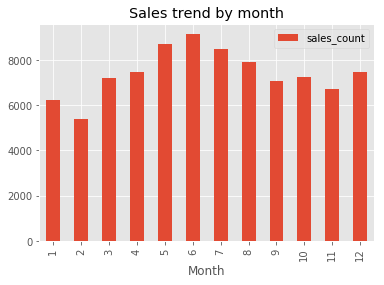

In [0]:
py_dc_data3 = sales_for_each_month.toPandas()
py_dc_data3.head()
df3 = py_dc_data3.set_index('Month')
df3[["sales_count"]].plot.bar()
plt.title('Sales trend by month')

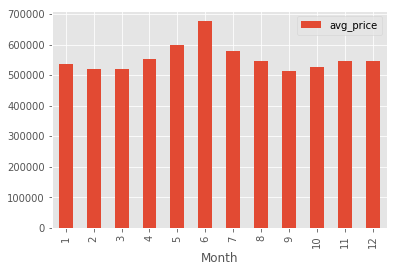

In [0]:
df3[["avg_price"]].plot.bar()

#### Average sales price per ward

In [0]:
sales_each_ward = df.groupBy(F.col("WARD"))\
                        .agg(F.avg("PRICE").alias("avg_price"))\
                        .where(F.col("WARD") != 'null')\
                        .orderBy(F.desc("avg_price"))
sales_each_ward.show()

+------+------------------+
|  WARD|         avg_price|
+------+------------------+
|Ward 3| 839629.5452536825|
|Ward 2|  727044.121484099|
|Ward 1|  598494.686404066|
|Ward 6| 556249.8941489361|
|Ward 4| 531690.7880845367|
|Ward 5| 415715.8010638298|
|Ward 8|278615.91025198484|
|Ward 7| 247307.5319199904|
+------+------------------+



In [0]:
py_dc_data2 = sales_each_ward.toPandas()
py_dc_data2.head()

,WARD,avg_price
0,Ward 3,839629.545254
1,Ward 2,727044.121484
2,Ward 1,598494.686404
3,Ward 6,556249.894149
4,Ward 4,531690.788085


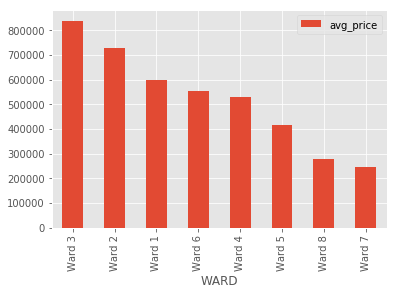

In [0]:
df2 = py_dc_data2.set_index('WARD')
df2[["avg_price"]].plot.bar()

Ward 3 has most avg_price in D.C.

## Sampling & Scatterplot
sample 5% of the data to plot a scatterplot:

In [0]:
df_sample = df_new.sample(withReplacement = False, fraction = 0.05, seed = 8)

# Convert to Pandas
py_df_sample = df_sample.toPandas()

py_df_sample.head()

,_c0,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,EYB,...,FAGI_TOTAL_2013,FAGI_MEDIAN_2013,FAGI_TOTAL_2011,FAGI_MEDIAN_2011,FAGI_TOTAL_2012,FAGI_MEDIAN_2012,FAGI_TOTAL_2014,FAGI_MEDIAN_2014,FAGI_TOTAL_2015,FAGI_MEDIAN_2015
0,59702,3,0,Forced Air,Y,1.0,7,4,1895.0,1967,...,8.244564e+07,51120.0,67070893,46580.5,7.654478e+07,49236.0,8.441106e+07,55925.0,98091822.0,61645.0
1,70890,3,1,Warm Cool,Y,1.0,12,7,1905.0,1969,...,9.606741e+07,47415.0,89517062,46693.0,9.642238e+07,47221.0,1.165576e+08,54943.0,124565445.0,57282.5
2,94814,1,2,Warm Cool,Y,1.0,6,3,1952.0,1964,...,6.839131e+07,49969.0,72050910,48382.0,7.159753e+07,51018.5,7.528196e+07,52425.0,78879964.0,51745.0
3,50628,1,1,Hot Water Rad,N,1.0,8,3,1913.0,1943,...,1.119406e+08,28176.5,100905873,27449.5,1.075708e+08,27870.5,1.128889e+08,29257.0,126189873.0,30443.0
4,42389,3,0,Forced Air,Y,1.0,10,5,1964.0,1981,...,1.201610e+08,74993.5,137593664,78133.0,1.507125e+08,79794.0,1.643907e+08,82203.0,170973446.0,81819.0


Draw plot on housing sales count by location

No handles with labels found to put in legend.


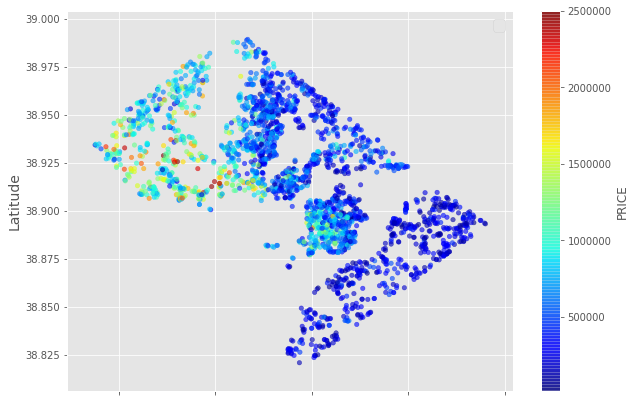

In [0]:
py_df_sample.plot(kind="scatter", x="LONGITUDE", y="LATITUDE",
    c="PRICE", cmap=plt.get_cmap("jet"),
    colorbar=True, alpha=0.6, figsize=(10,7),
)
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)
plt.legend(fontsize=16)
plt.show()

Compare with Washington D.C Map

<img src="https://raw.githubusercontent.com/elieric/is843/master/DC-Ward-Public-Trans.jpg" width="300" align="left"/>

# Regression Analysis

**Review**

In [76]:
d.columns

Index(['BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS', 'BEDRM',
       'AYB', 'EYB', 'STORIES', 'SALEDATE', 'PRICE', 'QUALIFIED', 'SALE_NUM',
       'GBA', 'BLDG_NUM', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN', 'EXTWALL',
       'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'USECODE', 'LANDAREA',
       'GIS_LAST_MOD_DTTM', 'SOURCE', 'ZIPCODE', 'LATITUDE', 'LONGITUDE',
       'ASSESSMENT_NBHD', 'CENSUS_TRACT', 'CENSUS_BLOCK', 'WARD', 'SQUARE',
       'QUADRANT', 'SALE_YR', 'SALE_MO', 'SALE_D'],
      dtype='object')

In [79]:
dc = d
print('done')

done


## Preparing Data

*   **Dropping improper datatypes**

In [80]:
dc = dc\
  .drop([
    'SALEDATE',
    'GIS_LAST_MOD_DTTM',
    'CENSUS_TRACT',
    'CENSUS_BLOCK',
    'SQUARE'],
    axis=1)
print('done')

done


In [81]:
dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57900 entries, 0 to 57899
Data columns (total 36 columns):
BATHRM             57900 non-null int32
HF_BATHRM          57900 non-null int32
HEAT               57900 non-null object
AC                 57900 non-null object
NUM_UNITS          57900 non-null float64
ROOMS              57900 non-null int32
BEDRM              57900 non-null int32
AYB                57900 non-null float64
EYB                57900 non-null int32
STORIES            57900 non-null float64
PRICE              57900 non-null float64
QUALIFIED          57900 non-null object
SALE_NUM           57900 non-null int32
GBA                57900 non-null float64
BLDG_NUM           57900 non-null int32
STYLE              57900 non-null object
STRUCT             57900 non-null object
GRADE              57900 non-null object
CNDTN              57900 non-null object
EXTWALL            57900 non-null object
ROOF               57900 non-null object
INTWALL            57900 non-nul

In [82]:
dc.dtypes

BATHRM               int32
HF_BATHRM            int32
HEAT                object
AC                  object
NUM_UNITS          float64
ROOMS                int32
BEDRM                int32
AYB                float64
EYB                  int32
STORIES            float64
PRICE              float64
QUALIFIED           object
SALE_NUM             int32
GBA                float64
BLDG_NUM             int32
STYLE               object
STRUCT              object
GRADE               object
CNDTN               object
EXTWALL             object
ROOF                object
INTWALL             object
KITCHENS           float64
FIREPLACES           int32
USECODE              int32
LANDAREA             int32
SOURCE              object
ZIPCODE            float64
LATITUDE           float64
LONGITUDE          float64
ASSESSMENT_NBHD     object
WARD                object
QUADRANT            object
SALE_YR             object
SALE_MO             object
SALE_D              object
dtype: object

In [83]:
dc.SALE_YR = dc.SALE_YR.astype('int32', copy=False)
dc.SALE_MO = dc.SALE_MO.astype('int32', copy=False)
dc.SALE_D = dc.SALE_D.astype('int32', copy=False)

dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57900 entries, 0 to 57899
Data columns (total 36 columns):
BATHRM             57900 non-null int32
HF_BATHRM          57900 non-null int32
HEAT               57900 non-null object
AC                 57900 non-null object
NUM_UNITS          57900 non-null float64
ROOMS              57900 non-null int32
BEDRM              57900 non-null int32
AYB                57900 non-null float64
EYB                57900 non-null int32
STORIES            57900 non-null float64
PRICE              57900 non-null float64
QUALIFIED          57900 non-null object
SALE_NUM           57900 non-null int32
GBA                57900 non-null float64
BLDG_NUM           57900 non-null int32
STYLE              57900 non-null object
STRUCT             57900 non-null object
GRADE              57900 non-null object
CNDTN              57900 non-null object
EXTWALL            57900 non-null object
ROOF               57900 non-null object
INTWALL            57900 non-nul

In [0]:
dc = pd.get_dummies(dc, prefix='HEAT_', columns=['HEAT'])
dc = pd.get_dummies(dc, prefix='AC_', columns=['AC'])
dc = pd.get_dummies(dc, prefix='QUALIFIED_', columns=['QUALIFIED'])
dc = pd.get_dummies(dc, prefix='STYLE_', columns=['STYLE'])
dc = pd.get_dummies(dc, prefix='STRUCT_', columns=['STRUCT'])
dc = pd.get_dummies(dc, prefix='GRADE_', columns=['GRADE'])
dc = pd.get_dummies(dc, prefix='CNDTN_', columns=['CNDTN'])
dc = pd.get_dummies(dc, prefix='EXTWALL_', columns=['EXTWALL'])
dc = pd.get_dummies(dc, prefix='ROOF_', columns=['ROOF'])
dc = pd.get_dummies(dc, prefix='INTWALL_', columns=['INTWALL'])
dc = pd.get_dummies(dc, prefix='USECODE_', columns=['USECODE'])
dc = pd.get_dummies(dc, prefix='SOURCE_', columns=['SOURCE'])
dc = pd.get_dummies(dc, prefix='ASSESSMENT_NBHD_', columns=['ASSESSMENT_NBHD'])
dc = pd.get_dummies(dc, prefix='WARD_', columns=['WARD'])
dc = pd.get_dummies(dc, prefix='QUADRANT_', columns=['QUADRANT'])

In [0]:
print(dc.describe())

             BATHRM     HF_BATHRM     NUM_UNITS         ROOMS         BEDRM  \
count  57900.000000  57900.000000  57900.000000  57900.000000  57900.000000   
mean       2.203437      0.650052      1.221071      7.448307      3.422798   
std        1.063606      0.607150      0.623997      2.307267      1.117695   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        1.000000      0.000000      1.000000      6.000000      3.000000   
50%        2.000000      1.000000      1.000000      7.000000      3.000000   
75%        3.000000      1.000000      1.000000      8.000000      4.000000   
max       12.000000     11.000000      6.000000     31.000000     20.000000   

                AYB           EYB       STORIES         PRICE      SALE_NUM  \
count  57900.000000  57900.000000  57900.000000  5.790000e+04  57900.000000   
mean    1934.523834   1969.799482      2.124596  5.799119e+05      1.855060   
std       30.615893     16.932781      3.947640  6.

### Separate

In [90]:
y = dc['PRICE']
X = dc.drop(['PRICE'], axis=1)

print('done')

done


### Split

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8 , random_state=100)
print('done')

done


## Correlation matrix
> *all columns*

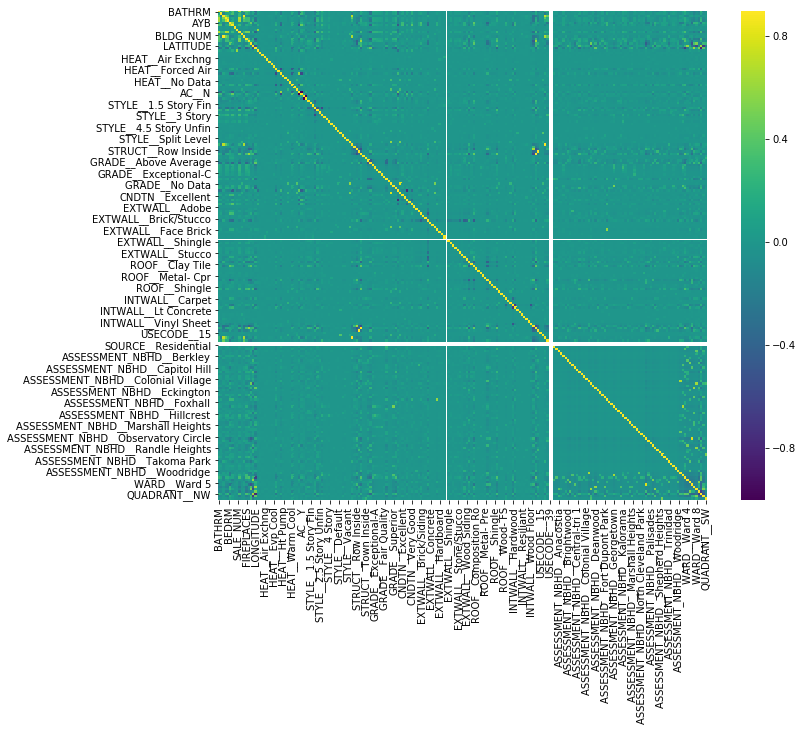

In [93]:
corrmat = X_train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True,cmap = "viridis")
plt.show()

## Gradient Boosting Regression
per [*Kaggle*](https://www.kaggle.com/ashishaggarwal12/dc-properties#Gradient-Boosting-regression-model-and-prediction-by-tuning-parameters)

In [96]:
# step 1
gbr1 = GradientBoostingRegressor(n_estimators=100) 
gbr1.fit(X_train, y_train) 
pred_gbr1=gbr1.predict(X_test)
print('done')

done


In [97]:
print("MSE for test",mean_squared_error(y_test,pred_gbr1))
print("R2 for test",r2_score(y_test,pred_gbr1))
print("Train score",gbr1.score(X_train, y_train))
print("Test score",gbr1.score(X_test, y_test))

MSE for test 62596905867.90207
R2 for test 0.7681354816361952
Train score 0.8800069958426311
Test score 0.7681354816361952
